Loading Breast Cancer Dataset...
Dataset loaded successfully!
Dataset shape: (569, 31)

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Benign (0): 212
Malignant (1): 357

=== Exploratory Data Analysis ===

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 

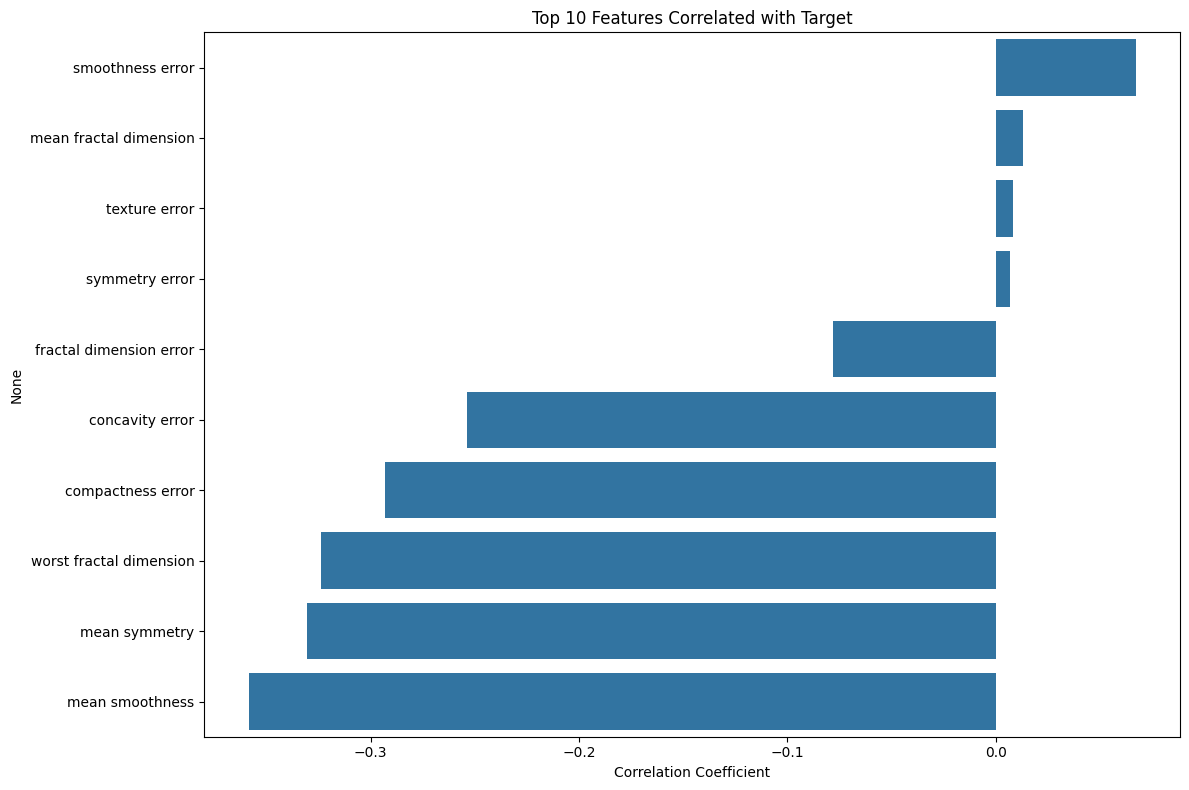

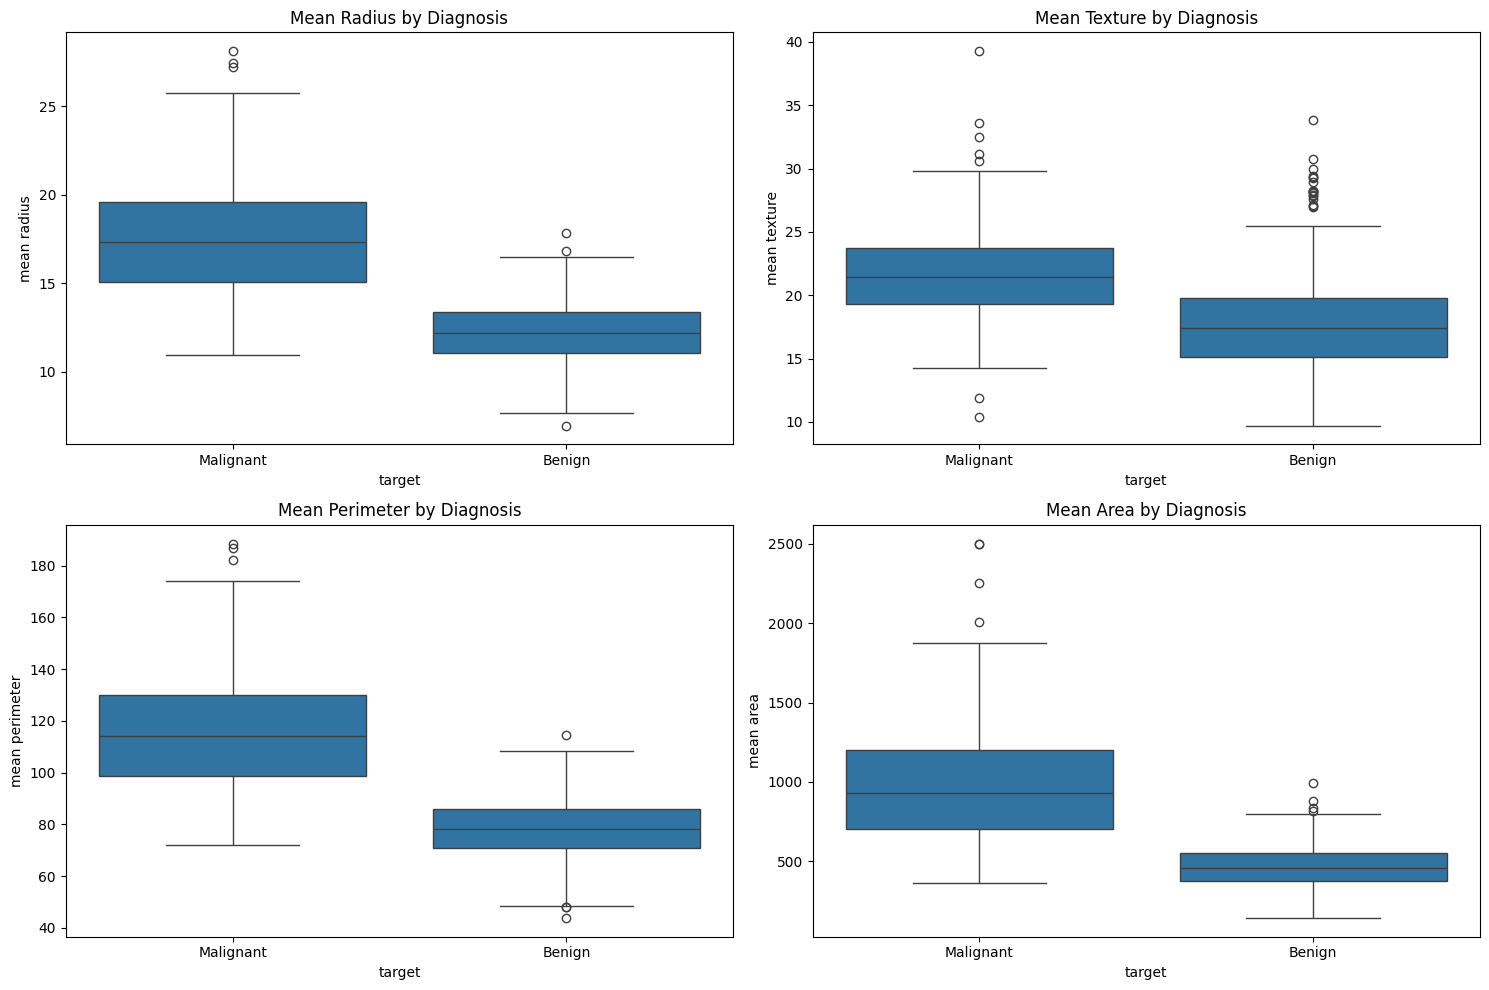

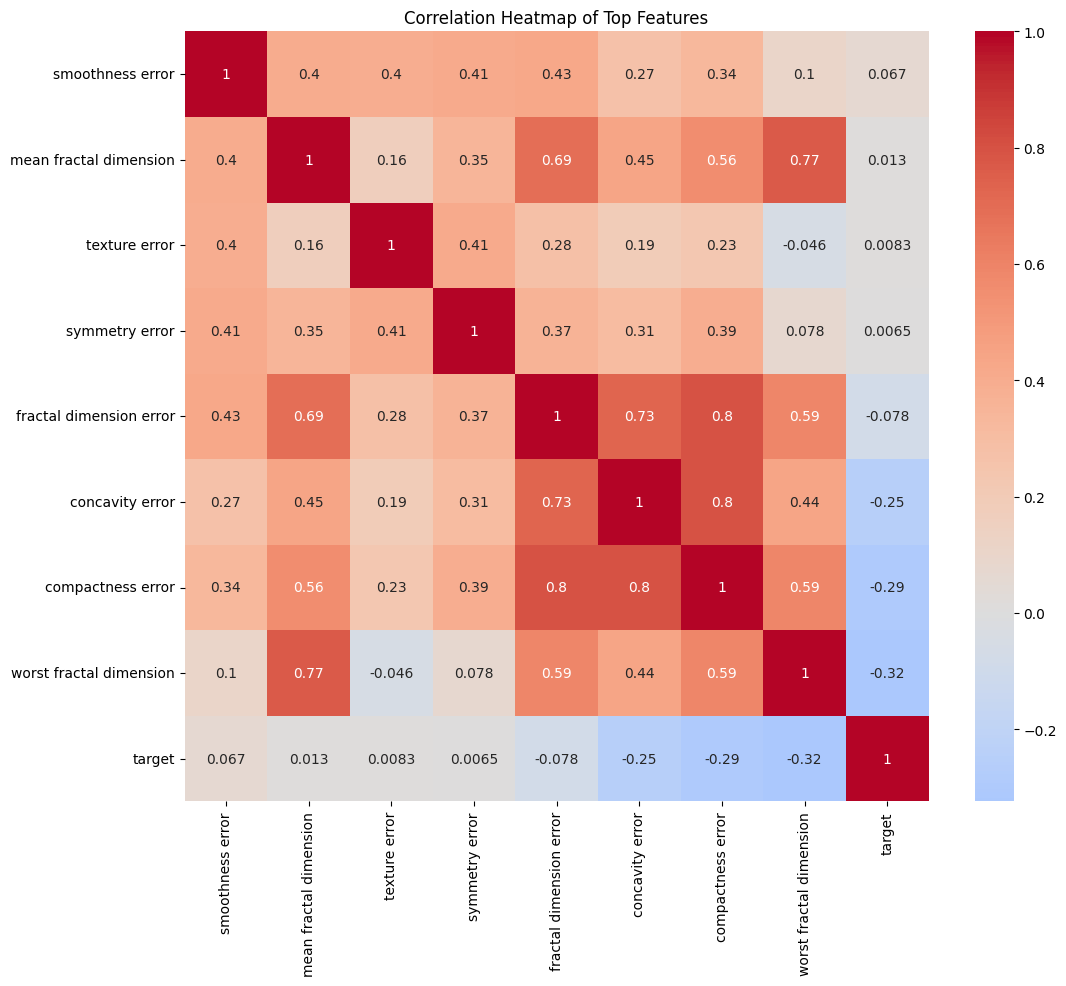

Training set: (455, 30)
Test set: (114, 30)

Class distribution in training set:
target
1    0.626374
0    0.373626
Name: proportion, dtype: float64

=== Training Logistic Regression ===
Accuracy: 0.9825
AUC Score: 0.9954
Cross-validation Accuracy: 0.9802 (+/- 0.0256)

=== Training Random Forest ===
Accuracy: 0.9561
AUC Score: 0.9937
Cross-validation Accuracy: 0.9538 (+/- 0.0469)

=== Training SVM ===
Accuracy: 0.9825
AUC Score: 0.9950
Cross-validation Accuracy: 0.9714 (+/- 0.0357)


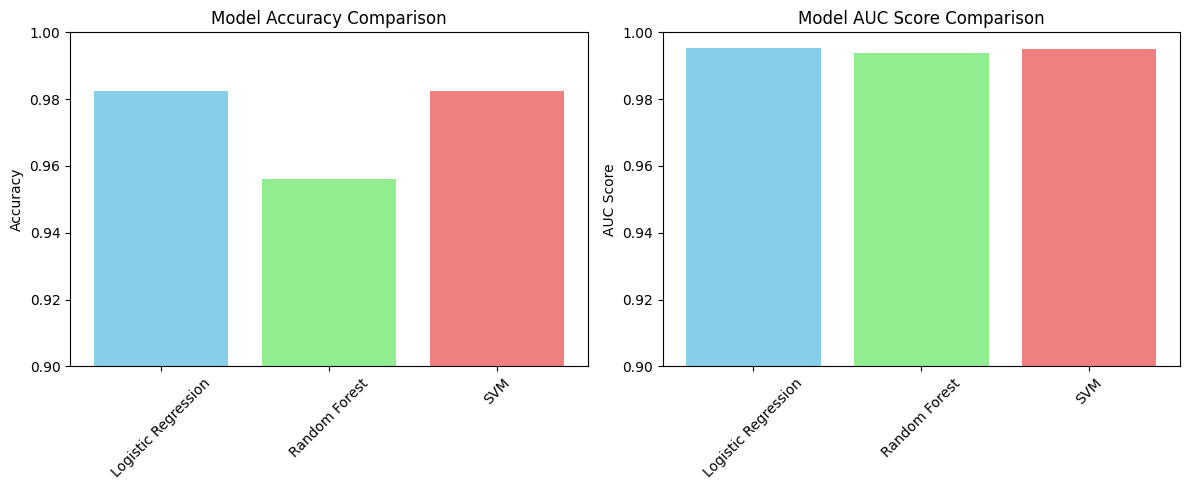


=== Best Model: Logistic Regression ===

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



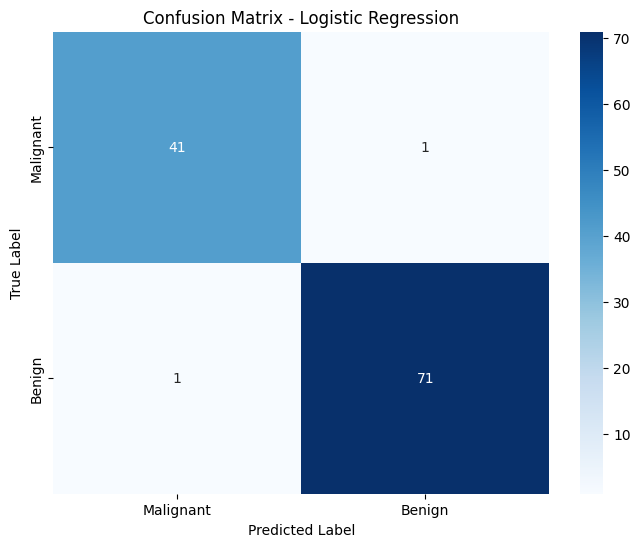

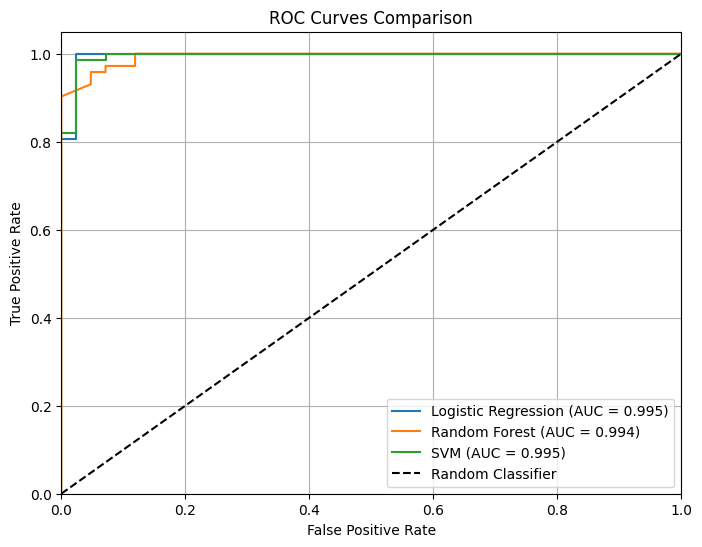


=== Hyperparameter Tuning ===

Model and scaler saved successfully!
Loaded model test accuracy: 0.3684


In [1]:
# cancer_classification.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading Breast Cancer Dataset...")
cancer_data = load_breast_cancer()
df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
df['target'] = cancer_data.target

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nTarget distribution:")
print(df['target'].value_counts())
print(f"\nBenign (0): {(df['target'] == 0).sum()}")
print(f"Malignant (1): {(df['target'] == 1).sum()}")

# EDA - Exploratory Data Analysis
print("\n=== Exploratory Data Analysis ===")

# Basic info
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

# Correlation with target
plt.figure(figsize=(12, 8))
correlations = df.corr()['target'].sort_values(ascending=False)[1:11]
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Top 10 Features Correlated with Target')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Distribution of key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Mean radius by target
sns.boxplot(x='target', y='mean radius', data=df, ax=axes[0,0])
axes[0,0].set_title('Mean Radius by Diagnosis')
axes[0,0].set_xticklabels(['Malignant', 'Benign'])

# Mean texture by target
sns.boxplot(x='target', y='mean texture', data=df, ax=axes[0,1])
axes[0,1].set_title('Mean Texture by Diagnosis')
axes[0,1].set_xticklabels(['Malignant', 'Benign'])

# Mean perimeter by target
sns.boxplot(x='target', y='mean perimeter', data=df, ax=axes[1,0])
axes[1,0].set_title('Mean Perimeter by Diagnosis')
axes[1,0].set_xticklabels(['Malignant', 'Benign'])

# Mean area by target
sns.boxplot(x='target', y='mean area', data=df, ax=axes[1,1])
axes[1,1].set_title('Mean Area by Diagnosis')
axes[1,1].set_xticklabels(['Malignant', 'Benign'])

plt.tight_layout()
plt.show()

# Correlation heatmap for top features
top_features = correlations.index[:8].tolist() + ['target']
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Top Features')
plt.show()

# Data Preparation
X = df.drop('target', axis=1)
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

# Model Training
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # Use scaled data for Logistic Regression and SVM
    if name in ['Logistic Regression', 'SVM']:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
    
    # Train model
    model.fit(X_tr, y_train)
    
    # Predictions
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    
    # Metrics
    accuracy = model.score(X_te, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy,
        'auc': auc_score
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Model Comparison
plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
accuracy_scores = [results[name]['accuracy'] for name in results.keys()]
plt.bar(results.keys(), accuracy_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.xticks(rotation=45)

# AUC comparison
plt.subplot(1, 2, 2)
auc_scores = [results[name]['auc'] for name in results.keys()]
plt.bar(results.keys(), auc_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model AUC Score Comparison')
plt.ylabel('AUC Score')
plt.ylim(0.9, 1.0)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Detailed evaluation for best model
best_model_name = max(results, key=lambda x: results[x]['auc'])
best_model = results[best_model_name]['model']
print(f"\n=== Best Model: {best_model_name} ===")

# Classification report
y_pred_best = results[best_model_name]['predictions']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Malignant', 'Benign']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['probabilities'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance (for Random Forest)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title('Top 15 Feature Importance - Random Forest')
    plt.tight_layout()
    plt.show()

# Hyperparameter Tuning for Best Model
print("\n=== Hyperparameter Tuning ===")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Save the best model and scaler
import os
os.makedirs('models', exist_ok=True)

with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nModel and scaler saved successfully!")

# Test the saved model
with open('models/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

test_accuracy = loaded_model.score(X_test, y_test)
print(f"Loaded model test accuracy: {test_accuracy:.4f}")

In [2]:
# train_model.py
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import pickle
import os

def load_and_prepare_data():
    """Load and prepare the breast cancer dataset"""
    cancer_data = load_breast_cancer()
    df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
    df['target'] = cancer_data.target
    
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Target distribution:\n{df['target'].value_counts()}")
    
    return df

def train_cancer_model():
    """Train and save the cancer classification model"""
    # Load data
    df = load_and_prepare_data()
    
    # Prepare features and target
    X = df.drop('target', axis=1)
    y = df['target']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model with hyperparameter tuning
    print("\nTraining Random Forest Classifier...")
    
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    model = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Evaluate model
    y_pred = model.best_estimator_.predict(X_test_scaled)
    y_pred_proba = model.best_estimator_.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\nBest parameters: {model.best_params_}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test AUC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))
    
    # Save model and scaler
    os.makedirs('models', exist_ok=True)
    
    with open('models/cancer_model.pkl', 'wb') as f:
        pickle.dump(model.best_estimator_, f)
    
    with open('models/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    print("\nModel and scaler saved successfully!")
    return model.best_estimator_

if __name__ == "__main__":
    train_cancer_model()

Dataset loaded successfully!
Shape: (569, 31)
Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Training Random Forest Classifier...

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.9561
Test AUC Score: 0.9932

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.95      0.93      0.94        42
      Benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


Model and scaler saved successfully!


In [11]:
import joblib
joblib.dump(best_model, "breast_cancer_model.pkl")


['breast_cancer_model.pkl']

In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)
model = joblib.load("breast_cancer_model.pkl")

@app.route("/predict", methods=["POST"])
def predict():
    features = request.json["features"]   # features list
    prediction = model.predict([features])[0]
    result = "malignant" if prediction == 0 else "benign"
    return jsonify({"prediction": result})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.43.217:5000
Press CTRL+C to quit
127.0.0.1 - - [19/Nov/2025 11:37:54] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [19/Nov/2025 11:37:54] "GET /favicon.ico HTTP/1.1" 404 -
192.168.43.217 - - [19/Nov/2025 11:38:00] "GET / HTTP/1.1" 404 -
192.168.43.217 - - [19/Nov/2025 11:38:01] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
FROM python:3.10

WORKDIR /app
COPY . /app

RUN pip install flask joblib scikit-learn numpy pandas

CMD ["python", "app.py"]
